In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, DenseNet121, Xception, MobileNetV2, EfficientNetB0, NASNetMobile, InceptionResNetV2, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Average
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

# Global variables
max_images_per_breed = 300  # Number of images per breed
total_epochs = 10  # Number of epochs

# Set directories
base_dir = os.getcwd()
thesis_dir = os.path.abspath(os.path.join(base_dir, ".."))
models_dir = os.path.join(thesis_dir, 'models')
class_indices_path = os.path.join(thesis_dir, 'class_indices.json')
train_dir = os.path.join(thesis_dir, 'images', 'train')
val_dir = os.path.join(thesis_dir, 'images', 'val')

def create_model(model_type, num_classes):
    if model_type == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'inceptionv3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'densenet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'xception':
        base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'mobilenetv2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'efficientnetb0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'nasnetmobile':
        base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'inceptionresnetv2':
        base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'vgg19':
        base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    
    return model

def create_ensemble(models, input_shape):
    # Create a single shared input for all models
    shared_input = tf.keras.Input(shape=input_shape)
    
    # Pass the shared input to each model and collect the outputs
    model_outputs = [model(shared_input) for model in models]
    
    # Average the outputs
    averaged_output = Average()(model_outputs)
    
    # Create an ensemble model with the shared input and averaged output
    ensemble_model = Model(inputs=shared_input, outputs=averaged_output)
    return ensemble_model

def load_image_paths_and_labels(directory, max_images_per_breed):
    image_paths = []
    labels = []
    for breed in os.listdir(directory):
        breed_path = os.path.join(directory, breed)
        if os.path.isdir(breed_path):
            breed_images = os.listdir(breed_path)[:max_images_per_breed]
            for image_name in breed_images:
                image_paths.append(os.path.join(breed_path, image_name))
                labels.append(breed)
    return image_paths, labels

def train(model_types=['vgg16', 'resnet50', 'inceptionv3']):
    if not os.path.exists(train_dir):
        raise FileNotFoundError(f"Training directory not found: {train_dir}")
    if not os.path.exists(val_dir):
        raise FileNotFoundError(f"Validation directory not found: {val_dir}")
    
    train_image_paths, train_labels = load_image_paths_and_labels(train_dir, max_images_per_breed)
    val_image_paths, val_labels = load_image_paths_and_labels(val_dir, max_images_per_breed)
    
    train_df = pd.DataFrame({'filename': train_image_paths, 'class': train_labels})
    val_df = pd.DataFrame({'filename': val_image_paths, 'class': val_labels})
    
    train_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_dataframe(
        train_df, x_col='filename', y_col='class', target_size=(224, 224), class_mode='categorical')
    val_generator = val_datagen.flow_from_dataframe(
        val_df, x_col='filename', y_col='class', target_size=(224, 224), class_mode='categorical')
    
    num_classes = len(train_generator.class_indices)
    
    # Save class indices to JSON
    with open(class_indices_path, 'w') as f:
        json.dump(train_generator.class_indices, f)

    # Create models for the ensemble
    models = [create_model(model_type, num_classes) for model_type in model_types]

    # Create an ensemble with a shared input
    ensemble_model = create_ensemble(models, input_shape=(224, 224, 3))
    
    # Compile the ensemble model
    ensemble_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the ensemble model
    history = ensemble_model.fit(train_generator, validation_data=val_generator, epochs=total_epochs)
    
    # Save the ensemble model
    model_save_path = os.path.join(models_dir, f'ensemble_{"_".join(model_types)}.h5')
    ensemble_model.save(model_save_path)
    print(f"Ensemble model saved to: {model_save_path}")
    
    # Plot training and validation accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(total_epochs)
    
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.show()

    # Plot training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    # Generate and display confusion matrix
    val_preds = ensemble_model.predict(val_generator)
    val_pred_classes = np.argmax(val_preds, axis=1)
    true_classes = val_generator.classes
    cm = confusion_matrix(true_classes, val_pred_classes)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
    disp.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=90)  # Rotate x-axis labels to vertical
    #plt.show()


Found 3000 validated image filenames belonging to 10 classes.
Found 2924 validated image filenames belonging to 10 classes.

Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 445s 4s/step - accuracy: 0.8295 - loss: 0.5593 - val_accuracy: 0.9429 - val_loss: 0.1972
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 397s 4s/step - accuracy: 0.9796 - loss: 0.0739 - val_accuracy: 0.9350 - val_loss: 0.2108
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 398s 4s/step - accuracy: 0.9880 - loss: 0.0456 - val_accuracy: 0.9456 - val_loss: 0.1916
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 398s 4s/step - accuracy: 0.9904 - loss: 0.0270 - val_accuracy: 0.9432 - val_loss: 0.1945
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 399s 4s/step - accuracy: 0.9929 - loss: 0.0206 - val_accuracy: 0.9473 - val_loss: 0.1904
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 398s 4s/step - accuracy: 0.9941 - loss: 0.0192 - val_accuracy: 0.9439 - val_loss: 0.1910
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 400s 4s/step - accuracy: 0.9943 - loss: 0.0164 - val_accuracy: 0.9463 - val_loss: 0.1911
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 399s 4s/step - accuracy: 0.9941 - loss: 0.0166 - val_accuracy: 0.9473 - val_loss: 0.

Ensemble model saved to: C:\Users\josej\Thesis\models\ensemble_inceptionresnetv2_nasnetmobile_xception.h5


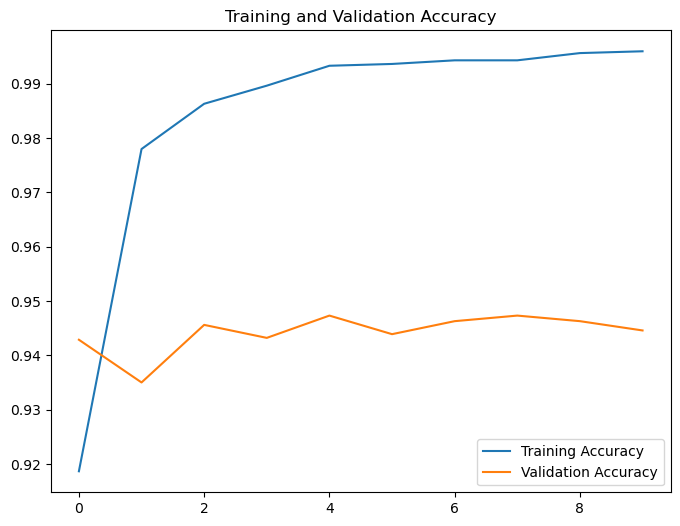

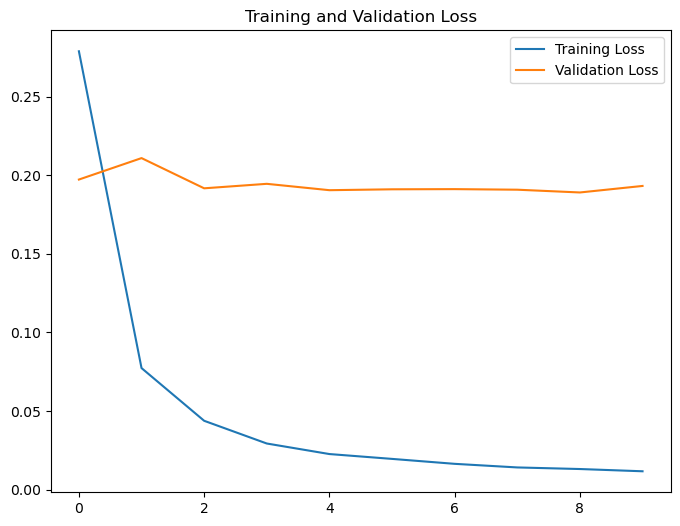

92/92 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step


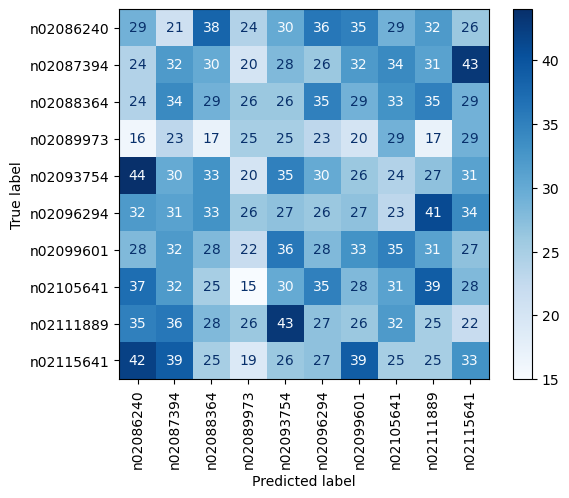

In [2]:
train(['inceptionresnetv2', 'nasnetmobile', 'xception'])

Found 3000 validated image filenames belonging to 10 classes.
Found 2924 validated image filenames belonging to 10 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 302s 3s/step - accuracy: 0.7379 - loss: 0.9052 - val_accuracy: 0.9224 - val_loss: 0.3836
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 276s 3s/step - accuracy: 0.9714 - loss: 0.1952 - val_accuracy: 0.9172 - val_loss: 0.3253
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.9817 - loss: 0.1384 - val_accuracy: 0.9265 - val_loss: 0.3052
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 268s 3s/step - accuracy: 0.9863 - loss: 0.1141 - val_accuracy: 0.9258 - val_loss: 0.3018
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.9922 - loss: 0.1001 - val_accuracy: 0.9285 - val_loss: 0.3040
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.9915 - loss: 0.0991 - val_accuracy: 0.9306 - val_loss: 0.2996
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.9960 - loss: 0.0967 - val_accuracy: 0.9309 - val_loss: 0.2983
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.9935 - loss: 0.0971 - val_accuracy: 0.9292 - val_loss: 0.

Ensemble model saved to: C:\Users\josej\Thesis\models\ensemble_inceptionv3_mobilenetv2_densenet121.h5


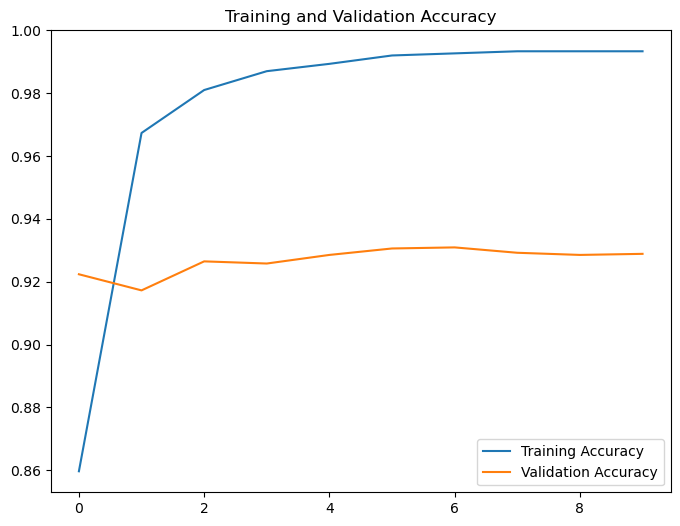

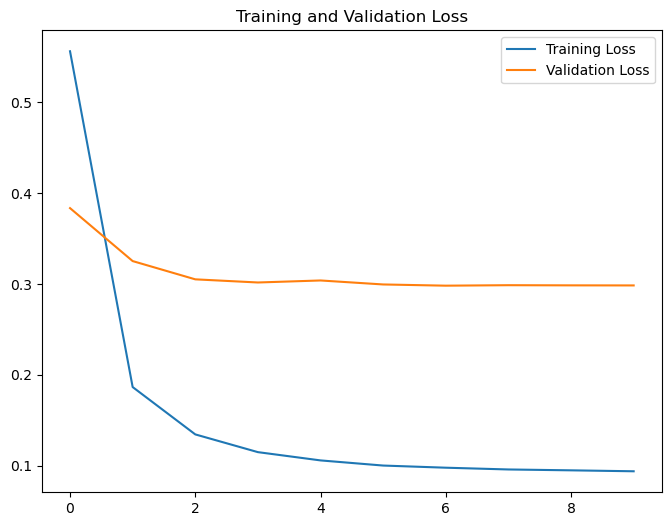

92/92 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step


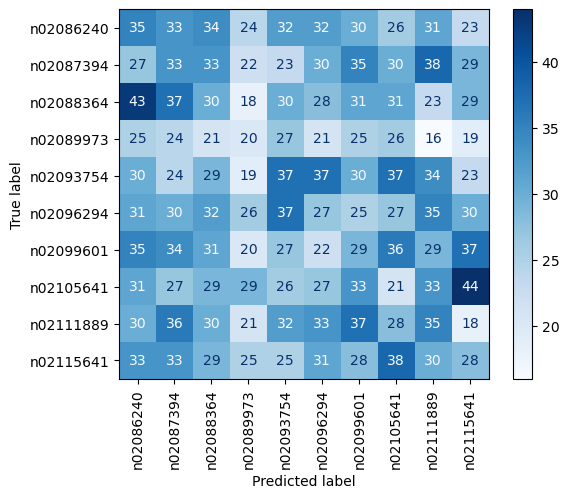

In [3]:
train(['inceptionv3', 'mobilenetv2', 'densenet121'])

Found 3000 validated image filenames belonging to 10 classes.
Found 2924 validated image filenames belonging to 10 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 334s 3s/step - accuracy: 0.7840 - loss: 0.6885 - val_accuracy: 0.9350 - val_loss: 0.2650
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 300s 3s/step - accuracy: 0.9741 - loss: 0.1169 - val_accuracy: 0.9278 - val_loss: 0.2292
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 300s 3s/step - accuracy: 0.9789 - loss: 0.0578 - val_accuracy: 0.9360 - val_loss: 0.2114
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 296s 3s/step - accuracy: 0.9922 - loss: 0.0301 - val_accuracy: 0.9384 - val_loss: 0.2033
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 293s 3s/step - accuracy: 0.9946 - loss: 0.0219 - val_accuracy: 0.9419 - val_loss: 0.2050
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 295s 3s/step - accuracy: 0.9931 - loss: 0.0220 - val_accuracy: 0.9391 - val_loss: 0.2002
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 296s 3s/step - accuracy: 0.9958 - loss: 0.0151 - val_accuracy: 0.9405 - val_loss: 0.2012
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 297s 3s/step - accuracy: 0.9959 - loss: 0.0139 - val_accuracy: 0.9412 - val_loss: 0.

Ensemble model saved to: C:\Users\josej\Thesis\models\ensemble_xception_inceptionv3_nasnetmobile.h5


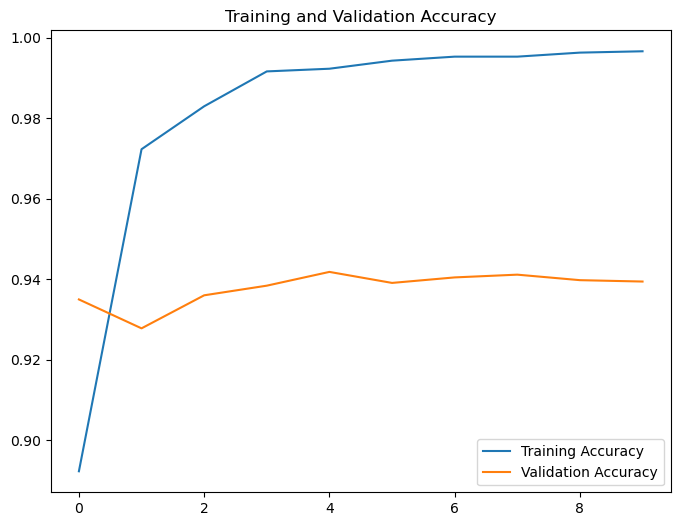

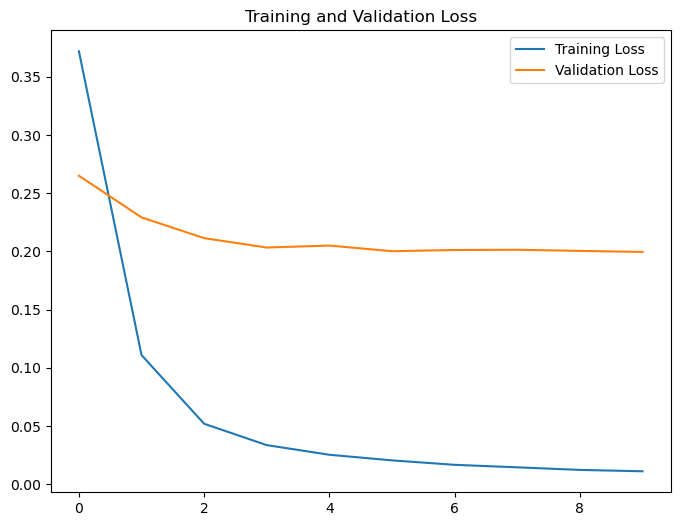

92/92 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step


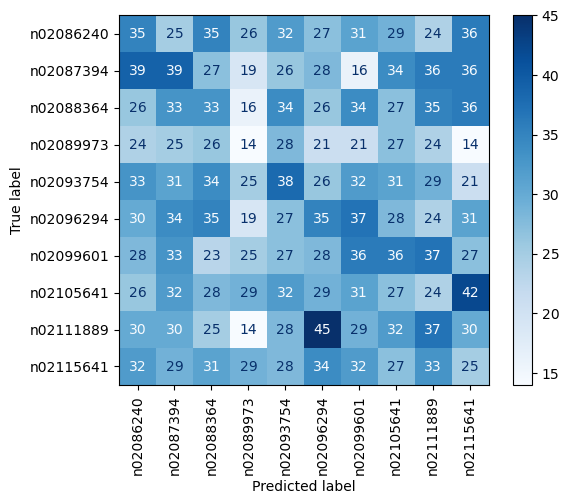

In [4]:
train(['xception', 'inceptionv3', 'nasnetmobile'])

Found 3000 validated image filenames belonging to 10 classes.
Found 2924 validated image filenames belonging to 10 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 448s 5s/step - accuracy: 0.7934 - loss: 0.6409 - val_accuracy: 0.9292 - val_loss: 0.2863
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 416s 4s/step - accuracy: 0.9700 - loss: 0.1199 - val_accuracy: 0.9391 - val_loss: 0.2410
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 414s 4s/step - accuracy: 0.9830 - loss: 0.0794 - val_accuracy: 0.9402 - val_loss: 0.2182
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 414s 4s/step - accuracy: 0.9827 - loss: 0.0564 - val_accuracy: 0.9422 - val_loss: 0.2024
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 413s 4s/step - accuracy: 0.9906 - loss: 0.0286 - val_accuracy: 0.9323 - val_loss: 0.2342
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 413s 4s/step - accuracy: 0.9893 - loss: 0.0306 - val_accuracy: 0.9402 - val_loss: 0.2060
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 413s 4s/step - accuracy: 0.9939 - loss: 0.0173 - val_accuracy: 0.9425 - val_loss: 0.2048
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 413s 4s/step - accuracy: 0.9924 - loss: 0.0183 - val_accuracy: 0.9429 - val_loss: 0.

Ensemble model saved to: C:\Users\josej\Thesis\models\ensemble_mobilenetv2_inceptionresnetv2_xception.h5


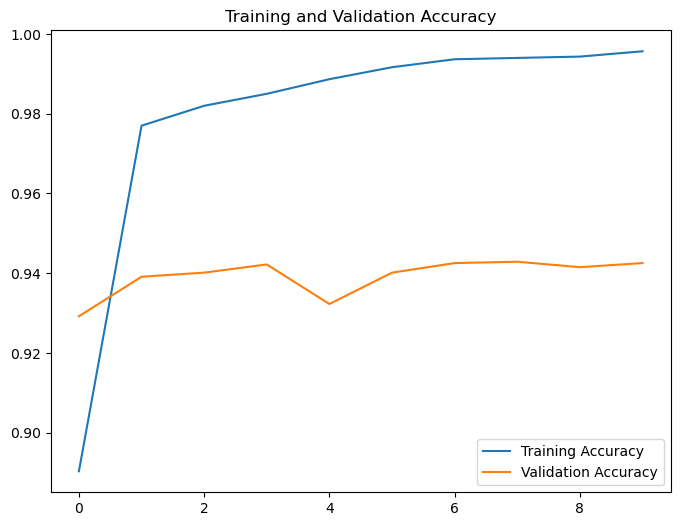

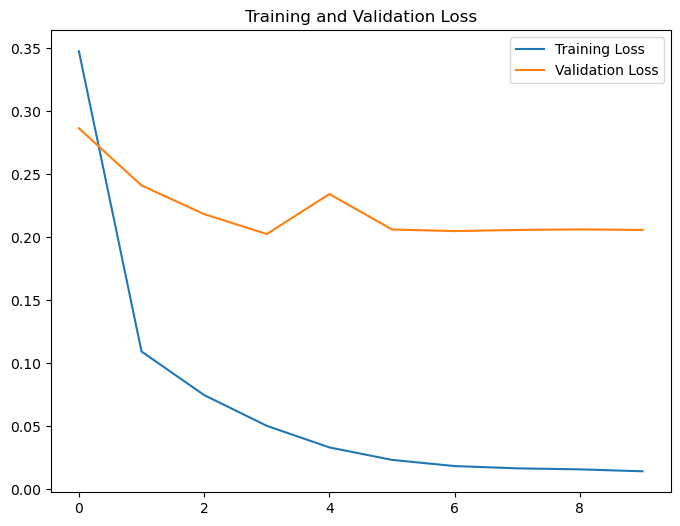

92/92 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step


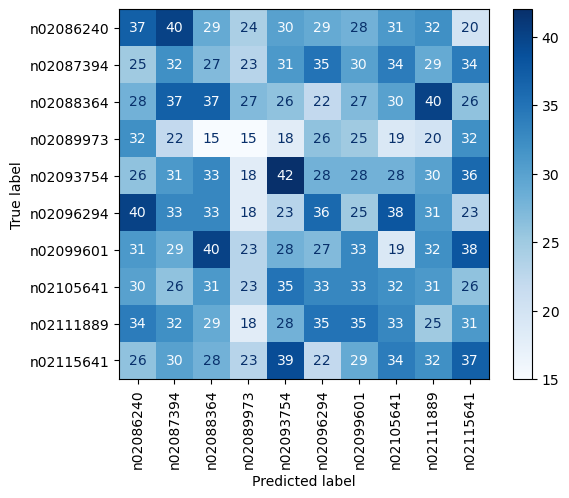

In [5]:
train(['mobilenetv2', 'inceptionresnetv2', 'xception'])

Found 3000 validated image filenames belonging to 10 classes.
Found 2924 validated image filenames belonging to 10 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.7684 - loss: 0.8502 - val_accuracy: 0.9186 - val_loss: 0.4161
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - accuracy: 0.9674 - loss: 0.2638 - val_accuracy: 0.9094 - val_loss: 0.3853
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.9789 - loss: 0.1638 - val_accuracy: 0.9162 - val_loss: 0.3430
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.9896 - loss: 0.1233 - val_accuracy: 0.9306 - val_loss: 0.3052
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.9927 - loss: 0.1077 - val_accuracy: 0.9282 - val_loss: 0.3080
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.9950 - loss: 0.1030 - val_accuracy: 0.9302 - val_loss: 0.3052
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.9958 - loss: 0.0974 - val_accuracy: 0.9295 - val_loss: 0.3045
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.9972 - loss: 0.0924 - val_accuracy: 0.9313 - val_loss: 0.

Ensemble model saved to: C:\Users\josej\Thesis\models\ensemble_nasnetmobile_densenet121_mobilenetv2.h5


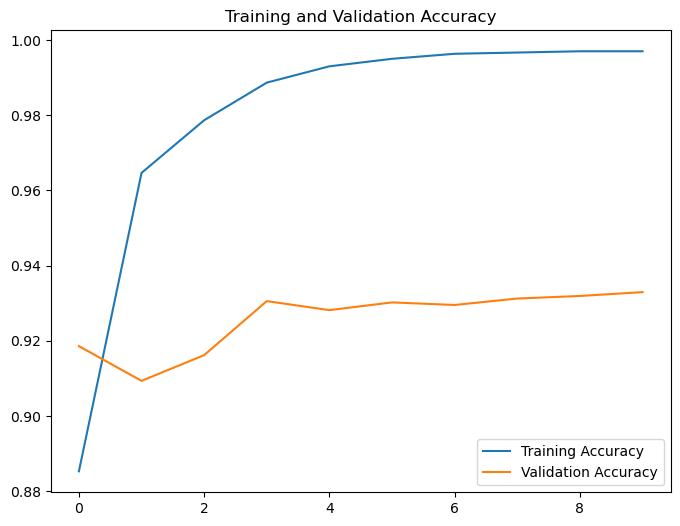

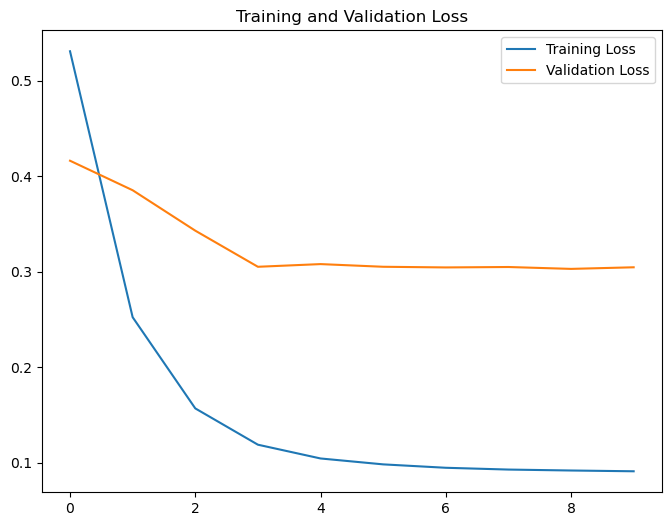

92/92 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step


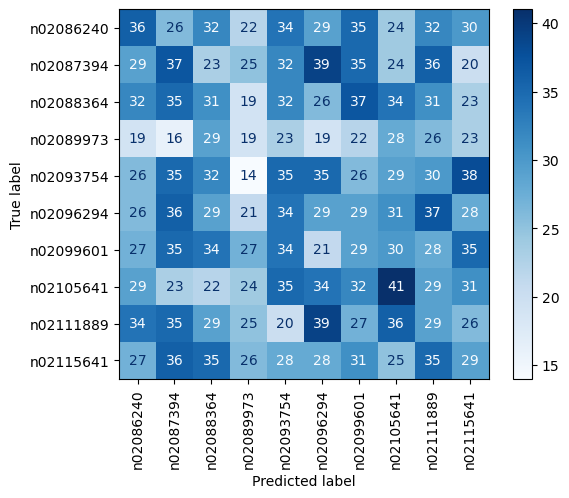

In [6]:
train(['nasnetmobile', 'densenet121', 'mobilenetv2'])

Found 3000 validated image filenames belonging to 10 classes.
Found 2924 validated image filenames belonging to 10 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 531s 5s/step - accuracy: 0.8372 - loss: 0.6101 - val_accuracy: 0.9316 - val_loss: 0.2738
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 496s 5s/step - accuracy: 0.9713 - loss: 0.1388 - val_accuracy: 0.9378 - val_loss: 0.2642
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 494s 5s/step - accuracy: 0.9880 - loss: 0.0877 - val_accuracy: 0.9354 - val_loss: 0.2508
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 493s 5s/step - accuracy: 0.9917 - loss: 0.0702 - val_accuracy: 0.9381 - val_loss: 0.2487
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 493s 5s/step - accuracy: 0.9941 - loss: 0.0659 - val_accuracy: 0.9381 - val_loss: 0.2467
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 493s 5s/step - accuracy: 0.9942 - loss: 0.0566 - val_accuracy: 0.9381 - val_loss: 0.2439
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 493s 5s/step - accuracy: 0.9964 - loss: 0.0567 - val_accuracy: 0.9378 - val_loss: 0.2445
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 493s 5s/step - accuracy: 0.9974 - loss: 0.0543 - val_accuracy: 0.9384 - val_loss: 0.

Ensemble model saved to: C:\Users\josej\Thesis\models\ensemble_inceptionresnetv2_xception_densenet121.h5


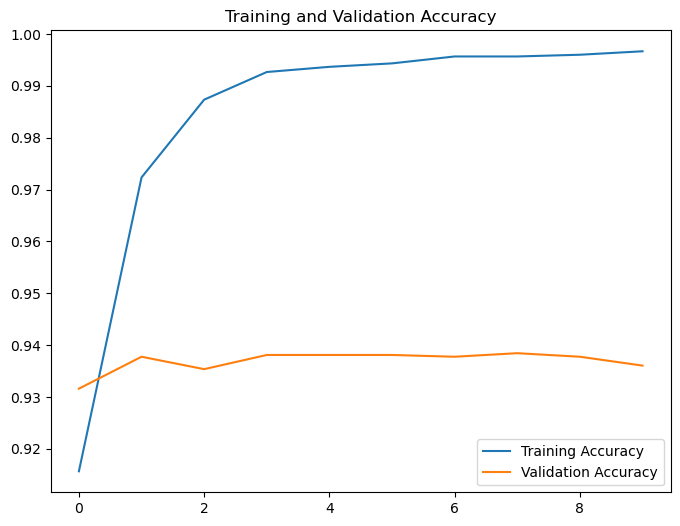

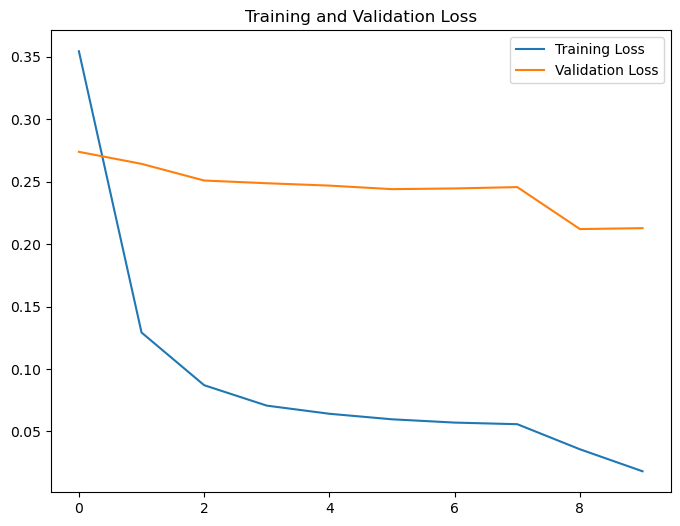

92/92 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step


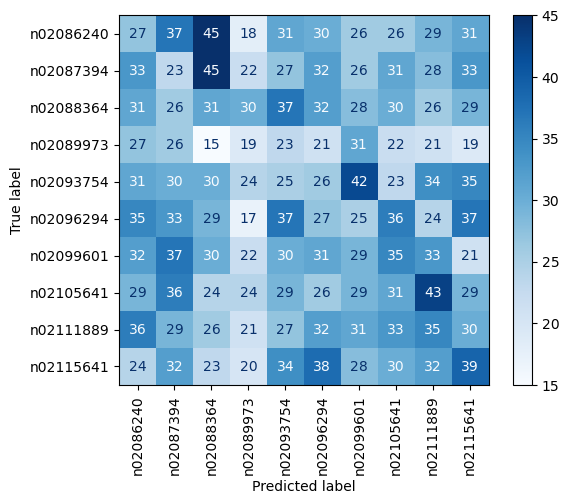

In [7]:
train(['inceptionresnetv2', 'xception', 'densenet121'])

Found 3000 validated image filenames belonging to 10 classes.
Found 2924 validated image filenames belonging to 10 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.7900 - loss: 0.7064 - val_accuracy: 0.9337 - val_loss: 0.2661
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.9769 - loss: 0.1230 - val_accuracy: 0.9340 - val_loss: 0.2160
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.9915 - loss: 0.0405 - val_accuracy: 0.9371 - val_loss: 0.2055
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.9902 - loss: 0.0334 - val_accuracy: 0.9384 - val_loss: 0.2049
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.9937 - loss: 0.0222 - val_accuracy: 0.9395 - val_loss: 0.2045
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.9920 - loss: 0.0226 - val_accuracy: 0.9395 - val_loss: 0.2042
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.9976 - loss: 0.0148 - val_accuracy: 0.9398 - val_loss: 0.2010
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.9951 - loss: 0.0171 - val_accuracy: 0.9384 - val_loss: 0.

Ensemble model saved to: C:\Users\josej\Thesis\models\ensemble_inceptionv3_nasnetmobile_mobilenetv2.h5


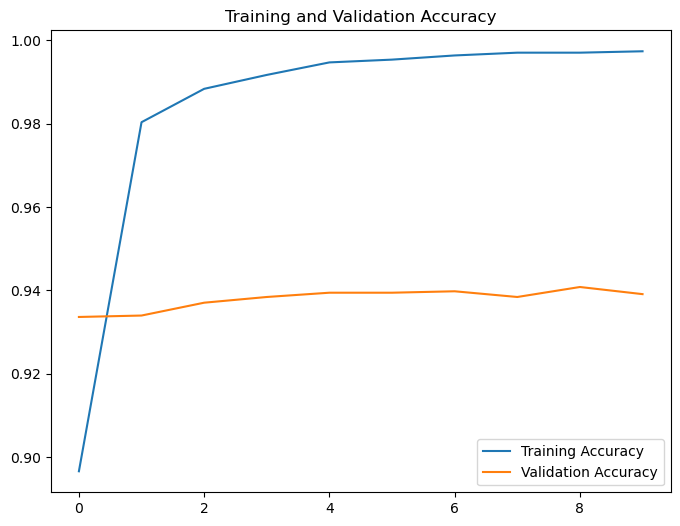

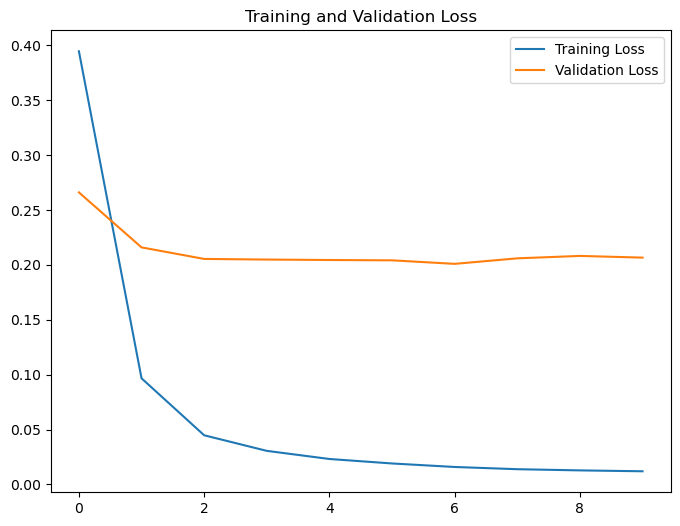

92/92 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step


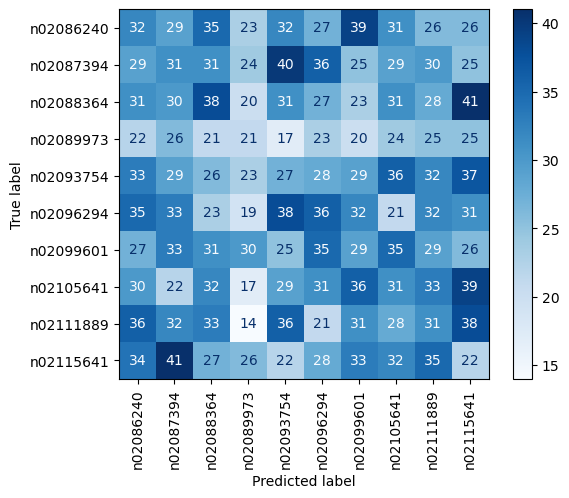

In [8]:
train(['inceptionv3', 'nasnetmobile', 'mobilenetv2'])

Found 3000 validated image filenames belonging to 10 classes.
Found 2924 validated image filenames belonging to 10 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 485s 5s/step - accuracy: 0.8311 - loss: 0.5634 - val_accuracy: 0.9323 - val_loss: 0.2250
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 454s 5s/step - accuracy: 0.9741 - loss: 0.0914 - val_accuracy: 0.9350 - val_loss: 0.2067
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 452s 5s/step - accuracy: 0.9841 - loss: 0.0533 - val_accuracy: 0.9425 - val_loss: 0.2041
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 450s 5s/step - accuracy: 0.9916 - loss: 0.0317 - val_accuracy: 0.9412 - val_loss: 0.1988
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 450s 5s/step - accuracy: 0.9919 - loss: 0.0241 - val_accuracy: 0.9405 - val_loss: 0.2022
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 449s 5s/step - accuracy: 0.9902 - loss: 0.0244 - val_accuracy: 0.9419 - val_loss: 0.2019
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 449s 5s/step - accuracy: 0.9960 - loss: 0.0162 - val_accuracy: 0.9402 - val_loss: 0.2016
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 449s 5s/step - accuracy: 0.9961 - loss: 0.0173 - val_accuracy: 0.9412 - val_loss: 0.

Ensemble model saved to: C:\Users\josej\Thesis\models\ensemble_inceptionresnetv2_inceptionv3_xception.h5


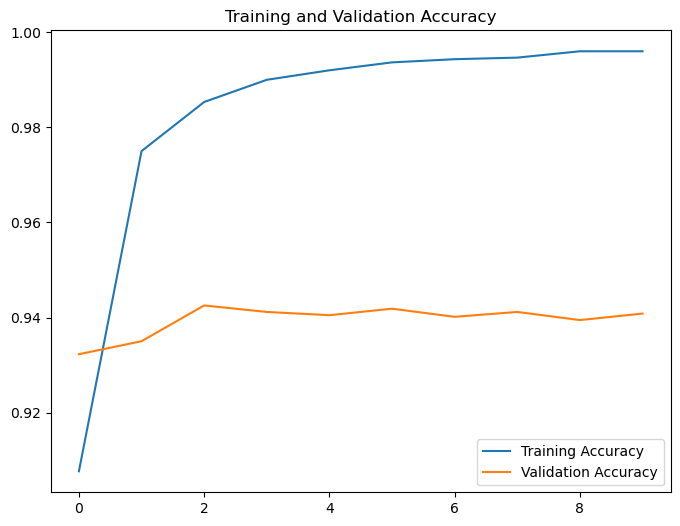

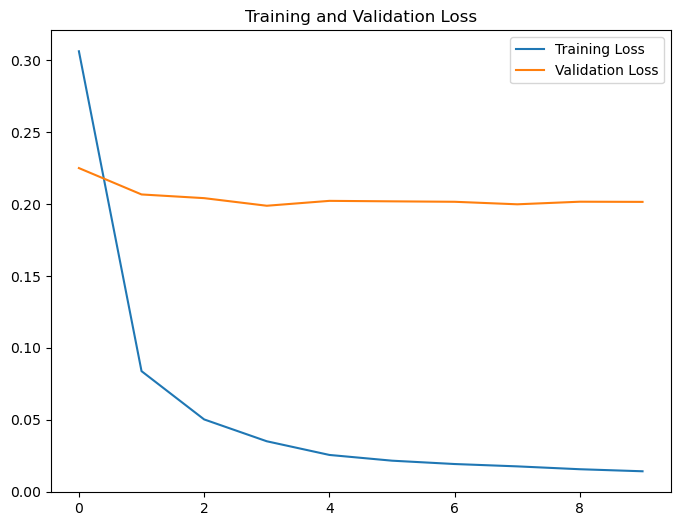

92/92 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step


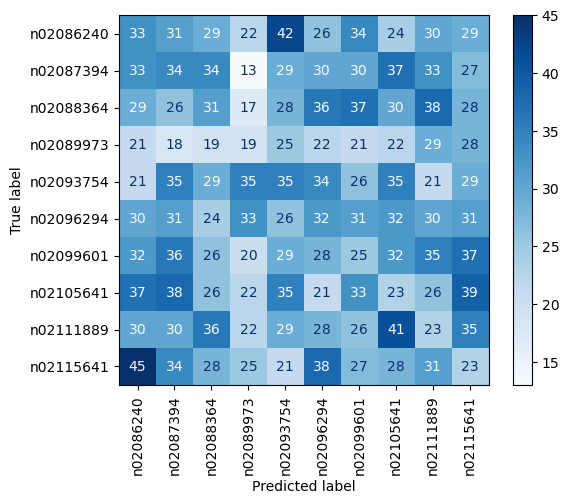

In [9]:
train(['inceptionresnetv2', 'inceptionv3', 'xception'])

Found 3000 validated image filenames belonging to 10 classes.
Found 2924 validated image filenames belonging to 10 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 401s 4s/step - accuracy: 0.7742 - loss: 0.8467 - val_accuracy: 0.9275 - val_loss: 0.4066
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 374s 4s/step - accuracy: 0.9715 - loss: 0.2551 - val_accuracy: 0.9155 - val_loss: 0.3099
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 374s 4s/step - accuracy: 0.9784 - loss: 0.1318 - val_accuracy: 0.9258 - val_loss: 0.2916
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 373s 4s/step - accuracy: 0.9843 - loss: 0.1183 - val_accuracy: 0.9248 - val_loss: 0.2958
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 373s 4s/step - accuracy: 0.9923 - loss: 0.0996 - val_accuracy: 0.9275 - val_loss: 0.2849
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 373s 4s/step - accuracy: 0.9918 - loss: 0.1054 - val_accuracy: 0.9275 - val_loss: 0.2834
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 372s 4s/step - accuracy: 0.9948 - loss: 0.0750 - val_accuracy: 0.9258 - val_loss: 0.2554
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 373s 4s/step - accuracy: 0.9947 - loss: 0.0561 - val_accuracy: 0.9333 - val_loss: 0.

Ensemble model saved to: C:\Users\josej\Thesis\models\ensemble_xception_densenet121_inceptionv3.h5


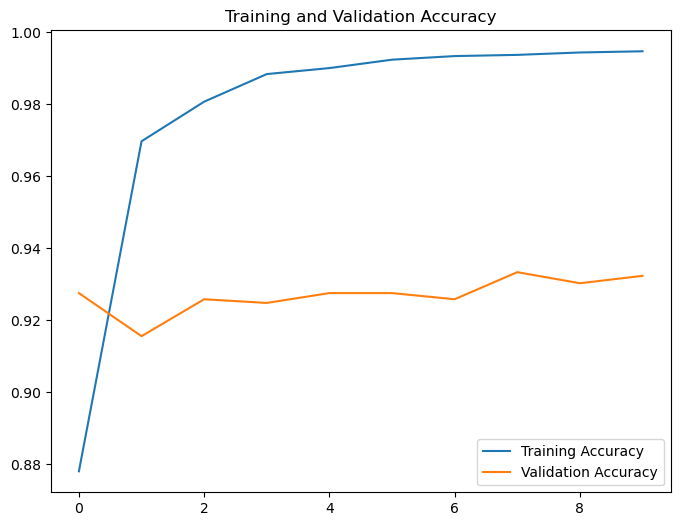

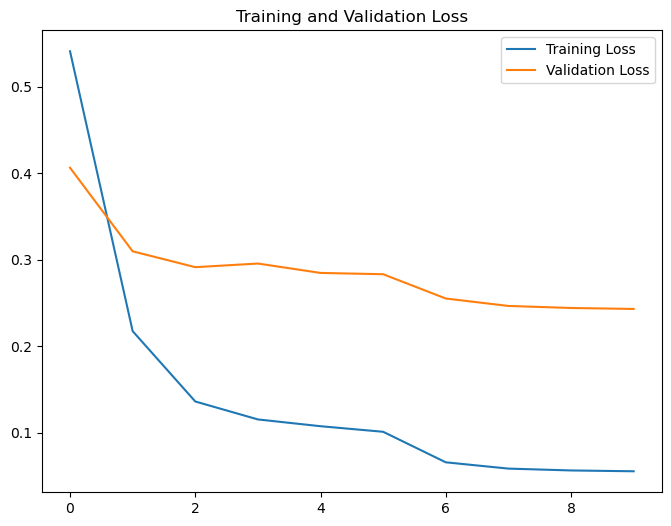

92/92 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step


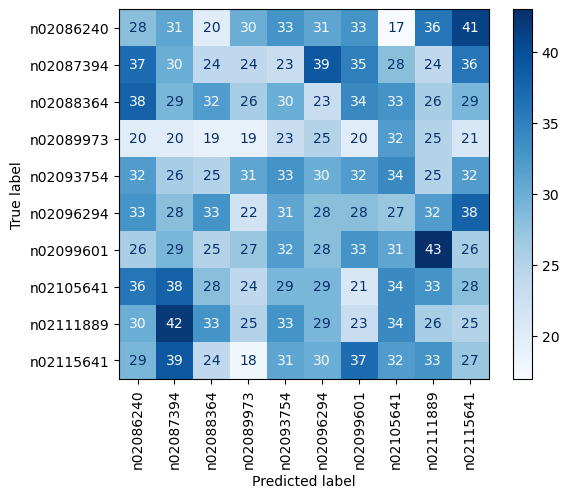

In [10]:
train(['xception', 'densenet121', 'inceptionv3'])

Found 3000 validated image filenames belonging to 10 classes.
Found 2924 validated image filenames belonging to 10 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 348s 3s/step - accuracy: 0.8084 - loss: 0.6428 - val_accuracy: 0.9374 - val_loss: 0.2194
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 301s 3s/step - accuracy: 0.9813 - loss: 0.0875 - val_accuracy: 0.9388 - val_loss: 0.2124
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 300s 3s/step - accuracy: 0.9874 - loss: 0.0453 - val_accuracy: 0.9425 - val_loss: 0.2002
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 300s 3s/step - accuracy: 0.9888 - loss: 0.0347 - val_accuracy: 0.9446 - val_loss: 0.1979
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 300s 3s/step - accuracy: 0.9955 - loss: 0.0228 - val_accuracy: 0.9432 - val_loss: 0.1990
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 300s 3s/step - accuracy: 0.9972 - loss: 0.0210 - val_accuracy: 0.9453 - val_loss: 0.1962
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 301s 3s/step - accuracy: 0.9976 - loss: 0.0159 - val_accuracy: 0.9436 - val_loss: 0.2004
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 301s 3s/step - accuracy: 0.9975 - loss: 0.0146 - val_accuracy: 0.9439 - val_loss: 0.

Ensemble model saved to: C:\Users\josej\Thesis\models\ensemble_mobilenetv2_inceptionresnetv2_nasnetmobile.h5


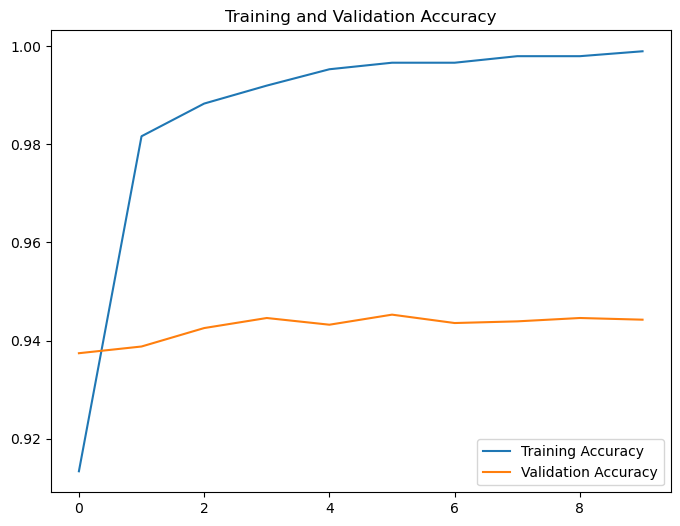

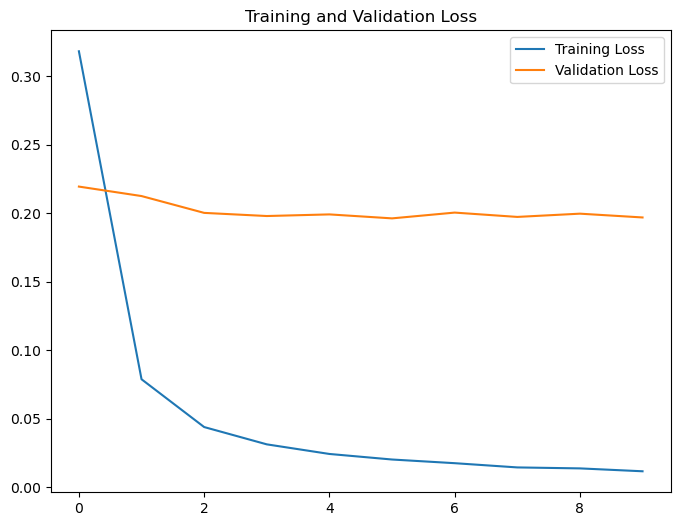

92/92 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step


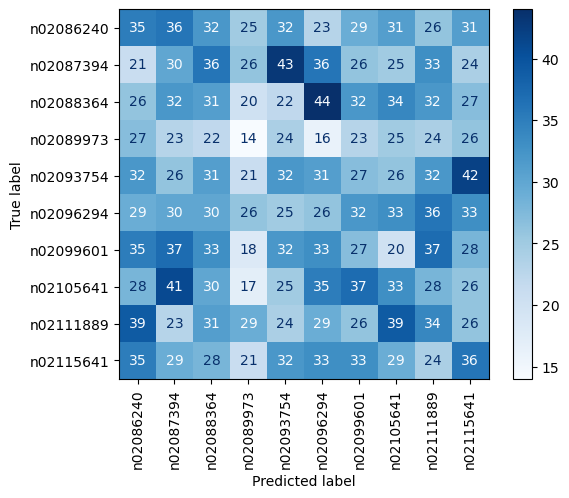

In [11]:
train(['mobilenetv2', 'inceptionresnetv2', 'nasnetmobile'])